In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import os
import copy
import holidays
import datetime as dt
from datetime import timedelta

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import multilabel_confusion_matrix, mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBClassifier, XGBRegressor
from scipy.stats import randint, uniform
import catboost as cb
import math
from imblearn.over_sampling import SMOTE, SVMSMOTE, KMeansSMOTE
from boruta import BorutaPy
from BorutaShap import BorutaShap

import shap

from shap_selection import feature_selection
shap.initjs()

pd.set_option('display.max_columns', 70)
pd.set_option('display.max_colwidth', None) #100 or None

os.getcwd()

'/Users/miek/Documents/DS4B/DS4BThesisSNCB'

In [152]:
all_punct

,index,TRAIN_ID,DAT_DEP,Retard_1pointage,PTCAR_1pointage,Retard_2pointage,PTCAR_2pointage,NAT_RGE,TRAIN_NUMBER,Retard_1pointage_valeur,Retard_2pointage_valeur,Validite_1pointage,Validite_2pointage,NB,Score,ScorePonctu
0,0,23052929.0,17/03/2019,72.0,936.0,NaN,NaN,,5689.0,1.0,0.0,1.0,0.0,1.0,1.0,100.0
1,1,23598801.0,15/06/2019,63.0,936.0,NaN,NaN,,5685.0,1.0,0.0,1.0,0.0,1.0,1.0,100.0
2,2,22682509.0,12/01/2019,-17.0,936.0,NaN,NaN,,6389.0,1.0,0.0,1.0,0.0,1.0,1.0,100.0
3,3,23377845.0,9/05/2019,122.0,936.0,NaN,NaN,,5683.0,1.0,0.0,1.0,0.0,1.0,1.0,100.0
4,4,22891694.0,16/02/2019,101.0,936.0,NaN,NaN,,5692.0,1.0,0.0,1.0,0.0,1.0,1.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4752006,310409,31975122.0,8/02/2023,124.0,1106.0,NaN,NaN,,5818.0,1.0,0.0,1.0,0.0,1.0,1.0,100.0
4752007,310410,31975221.0,8/02/2023,262.0,726.0,NaN,NaN,,5331.0,1.0,0.0,1.0,0.0,1.0,1.0,100.0
4752008,310411,31975392.0,8/02/2023,-12.0,726.0,NaN,NaN,,5337.0,1.0,0.0,1.0,0.0,1.0,1.0,100.0
4752009,310412,31975680.0,8/02/2023,-44.0,210.0,NaN,NaN,,829.0,1.0,0.0,1.0,0.0,1.0,1.0,100.0


In [2]:
# read in punctuality data
punct2019_1 = pd.read_csv("./data/Punctuality_2019_part1.csv", sep = ";")
punct2019_2 = pd.read_csv("./data/Punctuality_2019_part2.csv", sep = ";")
punct2020_1 = pd.read_csv("./data/Punctuality_2020_part1.csv", sep = ";")
punct2020_2 = pd.read_csv("./data/Punctuality_2020_part2.csv", sep = ";")
punct2021_1 = pd.read_csv("./data/Punctuality_2021_part1.csv", sep = ";")
punct2021_2 = pd.read_csv("./data/Punctuality_2021_part2.csv", sep = ";")
punct2022_1 = pd.read_csv("./data/Punctuality_2022_part1.csv", sep = ";")
punct2022_2 = pd.read_csv("./data/Punctuality_2022_part2.csv", sep = ";")
punct2023 = pd.read_csv("./data/Punctuality_2023.csv", sep = ";")
all_punct = pd.concat([punct2019_1, punct2019_2, punct2020_1, punct2020_2, punct2021_1, punct2021_2, punct2022_1, punct2022_2, punct2023], axis = 0)
all_punct = all_punct[all_punct['TRAIN_ID'].notna()].reset_index()

# read in justifications data
justifs = pd.read_parquet("~/Downloads/justif_parquet")
justifs = justifs[justifs['TRAIN_ID_resp'].notna()]
justifs['p_resp'] = justifs['trno_resp'].apply(lambda x: 1 if ((x >= 7000) & (x <= 8999)) else 0)

# duplicate columns of interest to update with info from the train that was ultimately responsable for the knock-on delay
#justifs['justification_dt_originator'] = justifs['justification_dt']
#justifs['trno_resp_originator'] = justifs['trno_resp']
#justifs['TRAIN_ID_resp_originator'] = justifs['TRAIN_ID_resp']

# sort justifs by justification_dt
justifs = justifs.sort_values(by = ['justification_dt']).reset_index(drop = True)

# add combined ID column
#justifs['combinedID'] = justifs[['TRAIN_ID_resp', 'REF_TOD_IMPACTED_TRAIN']].values.tolist()


## Getting the label - preparation: we transform justifs to account for knock-on delays

In [189]:
def find_chain(row, df):
    impacted_train_id = row['REF_TOD_IMPACTED_TRAIN']
    responsible_train_id = row['TRAIN_ID_resp']
    justification_dt = row['justification_dt']

    # Initialize the list of responsible train IDs
    chain = [responsible_train_id]

    # Create a boolean mask for prior delays within 5 minutes
    mask = (df['justification_dt'] < justification_dt) & \
           (df['justification_dt'] >= justification_dt - timedelta(minutes=5)) & \
           (df['REF_TOD_IMPACTED_TRAIN'] == responsible_train_id)

    # Find the indices of prior delays that satisfy the mask
    prior_indices = np.where(mask)[0]

    # Iterate over the indices and recursively find the chain
    for idx in prior_indices:
        prior_row = df.iloc[idx]
        prior_chain = find_chain(prior_row, df)
        chain.extend(prior_chain)

    return chain

justifs['resp_chain'] = justifs.apply(lambda row: find_chain(row, justifs), axis=1)
justifs['resp_chain'] = justifs['resp_chain'].apply(lambda x: list(set(x)))
justifs[['REF_TOD_IMPACTED_TRAIN', 'TRAIN_ID_resp', 'trno_resp', 'justification_dt', 'resp_chain']]

,REF_TOD_IMPACTED_TRAIN,TRAIN_ID_resp,trno_resp,justification_dt,resp_chain
0,22626539,22628988.0,7716.0,2019-01-02 05:55:39,[22628988.0]
1,22631315,22631227.0,7301.0,2019-01-02 06:18:04,[22631227.0]
2,22631227,22631100.0,1728.0,2019-01-02 06:29:52,[22631100.0]
3,22628196,22629554.0,4677.0,2019-01-02 06:31:33,[22629554.0]
4,22628791,22630077.0,7400.0,2019-01-02 06:33:17,[22630077.0]
...,...,...,...,...,...
528943,32465273,32464825.0,7009.0,2023-05-03 09:05:16,[32464825.0]
528944,32465273,32464825.0,7009.0,2023-05-03 09:05:16,[32464825.0]
528945,32465273,32464825.0,7009.0,2023-05-03 09:05:16,[32464825.0]
528946,32463246,32465562.0,7629.0,2023-05-03 09:06:17,[32465562.0]


In [266]:
print(round(justifs['resp_chain'].apply(lambda x: len(x)).value_counts(normalize=True)*100, 2))

resp_chain
1     85.22
2     11.65
3      2.21
4      0.63
5      0.20
6      0.06
7      0.02
8      0.01
9      0.00
11     0.00
10     0.00
13     0.00
Name: proportion, dtype: float64


In [157]:
# read
justifs = pd.read_parquet("~/Downloads/justifs_originated/justifs_chained_5min.parquet")

In [6]:
# save file
#justifs.to_parquet("~/Downloads/justifs_originated/justifs_chained_5min.parquet")

# read file
#justifs = pd.read_parquet("~/Downloads/justifs_originated/justifs_chained_5min.parquet")

## Getting the label - Creation: we join transformed justifs to punctuality data, then group by responsible P-train.
We assign the positive label (1) if any of the trains impacted by the P-train failed to meet the service level for punctuality (>= 6m delay)

In [4]:
# from all_punct get train_ids of trains that were crit. late, left merge with justifs to keep only guilty trains
punct_justifs = justifs.merge(all_punct[['TRAIN_ID', 'Retard_1pointage_valeur']], left_on='REF_TOD_IMPACTED_TRAIN', right_on='TRAIN_ID', how = 'left')

unique_values = set()
for resp_list in punct_justifs['resp_chain']:
    unique_values.update(resp_list)
unique_values = list(unique_values)

# make dictionary of train IDs and their respective train numbers
train_id_dict = dict(zip(justifs['TRAIN_ID_resp'], justifs['trno_resp']))

# match train IDs in 'resp_chain' to respective train numbers
punct_justifs['resp_chain_trno'] = punct_justifs['resp_chain'].apply(lambda x: [train_id_dict[i] for i in x])
punct_justifs[['REF_TOD_IMPACTED_TRAIN', 'resp_chain', 'resp_chain_trno']]

# remove trains we don't have punctuality data for
punct_justifs = punct_justifs[punct_justifs['Retard_1pointage_valeur'].notna()]

# make a split dataframe for grouping by train number purposes
def split_rows(df):
    df = df.set_index(['REF_TOD_IMPACTED_TRAIN'])[['resp_chain', 'resp_chain_trno']].apply(pd.Series.explode).reset_index()
    return pd.concat([df], ignore_index=True)

punct_justifs_copy = punct_justifs.copy()
punct_justifs_split = split_rows(punct_justifs_copy)
punct_justifs_split = punct_justifs_split.merge(punct_justifs[['REF_TOD_IMPACTED_TRAIN', 'Retard_1pointage_valeur']],
                                                on = 'REF_TOD_IMPACTED_TRAIN')
punct_justifs_split['label'] = punct_justifs_split['Retard_1pointage_valeur'].apply(lambda x: 1 if x != 0 else 0)
punct_justifs_split.drop(columns=['Retard_1pointage_valeur'], inplace=True)

# get statistics per train number
punct_justifs_grouped = punct_justifs_split.groupby(['resp_chain', 'resp_chain_trno']).agg(
    count_impacted = ('REF_TOD_IMPACTED_TRAIN', 'size'),
    count_impacted_ontime = ('label', 'sum')
).reset_index()
punct_justifs_grouped['service_level'] = punct_justifs_grouped['count_impacted_ontime'] / punct_justifs_grouped['count_impacted']

# keep only trains that were crit. late (>= 6m delay in final commercial stop)
punct_justifs = punct_justifs[punct_justifs['Retard_1pointage_valeur'] == 0.0]

# P-trains to consider: rows dataframe
p_trains = all_punct[(all_punct['TRAIN_NUMBER']  >= 7000) & (all_punct['TRAIN_NUMBER'] <= 8999)].reset_index().drop(columns=['level_0', 'index'])

# Create label
p_trains['label'] = p_trains['TRAIN_ID'].isin(unique_values).astype(int)
print(p_trains['label'].value_counts(normalize=True))

label
0    0.690296
1    0.309704
Name: proportion, dtype: float64


## Reduce rows and limit data

In [6]:
# reduce dataframe to only columns of interest
p_trains_labeled = p_trains[['TRAIN_ID', 'TRAIN_NUMBER', 'NB', 'label']] # chose label for class

p_trains_labeled


,TRAIN_ID,TRAIN_NUMBER,NB,label
0,22716050.0,7612.0,1.0,0
1,22792578.0,7612.0,1.0,1
2,22782782.0,7612.0,1.0,0
3,22733565.0,7612.0,1.0,0
4,22638436.0,7612.0,1.0,0
...,...,...,...,...
389619,31812052.0,7053.0,1.0,0
389620,31812236.0,7864.0,1.0,1
389621,31973261.0,8985.0,1.0,0
389622,31972835.0,7650.0,1.0,0


In [138]:
# read in stops data
df = pd.read_parquet("~/Downloads/all_stops_ungrouped/rush_comm_stops_post_covid.parquet")

# group stops by train
df_intermediate = df.groupby(['REF_TOD_TRAIN_ID', 'YEAR_DEP', 'month', 'season', 'weekend', 'holiday',
                 'dep_hour_origin', 'day_origin', 'date_origin', 'rush']).agg(stations_count=("REF_PTCAR_NO", "size")).reset_index()

# add target column from p_trains_labeled
df_intermediate = df_intermediate.merge(p_trains_labeled,
                                        left_on='REF_TOD_TRAIN_ID', right_on='TRAIN_ID', how = 'left')

# remove NA / dates past the all_punct cutoff (12th april 2023)
df_intermediate = df_intermediate[df_intermediate['TRAIN_ID'].notna()]

# change dtypes of some variables for encoding
df_intermediate['YEAR_DEP'] = df_intermediate['YEAR_DEP'].astype(str)
df_intermediate['month'] = df_intermediate['month'].astype(str)

df_intermediate['date_origin'] = df_intermediate['date_origin'].astype(str)
df_intermediate['day_origin'] = df_intermediate['date_origin'].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d').strftime('%A'))
df_intermediate['day_origin'] = df_intermediate['day_origin'].astype(str)

df_intermediate['dep_hour_origin'] = df_intermediate['dep_hour_origin'].apply(lambda x: (x - 6) / 3 if x < 12 else (x - 16) / 3)

df_intermediate['TRAIN_NUMBER'] = df_intermediate['TRAIN_NUMBER'].astype(str)

df_intermediate['weekend'] = df_intermediate['weekend'].astype(bool)
df_intermediate['holiday'] = df_intermediate['holiday'].astype(bool)

df_intermediate['label'] = df_intermediate['label'].astype(int)


# check
df_intermediate

,REF_TOD_TRAIN_ID,YEAR_DEP,month,season,weekend,holiday,dep_hour_origin,day_origin,date_origin,rush,stations_count,TRAIN_ID,TRAIN_NUMBER,NB,label
514,30284099,2022,5.0,Spring,False,False,0.155556,Thursday,2022-05-12,evening_rush,14,30284099.0,8087.0,1.0,0
516,30284108,2022,5.0,Spring,False,False,0.355556,Thursday,2022-05-12,evening_rush,2,30284108.0,8067.0,1.0,0
517,30284109,2022,5.0,Spring,False,False,0.355556,Thursday,2022-05-12,evening_rush,15,30284109.0,8076.0,1.0,0
520,30284121,2022,5.0,Spring,False,False,0.450000,Thursday,2022-05-12,evening_rush,13,30284121.0,8088.0,1.0,0
521,30284122,2022,5.0,Spring,False,False,0.061111,Thursday,2022-05-12,evening_rush,15,30284122.0,8075.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410717,32345237,2023,4.0,Spring,False,False,0.005556,Wednesday,2023-04-12,morning_rush,7,32345237.0,7051.0,1.0,0
410718,32345238,2023,4.0,Spring,False,False,0.250000,Wednesday,2023-04-12,morning_rush,17,32345238.0,7962.0,1.0,0
410719,32345240,2023,4.0,Spring,False,False,0.266667,Wednesday,2023-04-12,morning_rush,16,32345240.0,7960.0,1.0,0
410722,32345253,2023,4.0,Spring,False,False,0.594444,Wednesday,2023-04-12,morning_rush,8,32345253.0,7963.0,1.0,0


## make station stops one-hot encoded, as features

In [8]:
network_char_example_trains = pd.read_csv('./data/network_char_example_trains_5mins_weighted.csv') # remove "_newtrains" for only real obs
network_char_example_trains['TRAIN_NUMBER'] = network_char_example_trains['TRAIN_NUMBER'].astype(str) + '.0'
network_char_example_trains

,TRAIN_NUMBER,PAGERANK,INDEGREE,OUTDEGREE,W_INDEGREE,W_OUTDEGREE,1003_0_ATHUS-FRONTIERE,1015_0_ESSEN-GRENS,1026_0_1838.0,1026_0_MEER-GRENS,1042_941_SCHAARBEEK-GROEP R,1042_941_Y.SCHAARBEEK-CARWASH,1064_0_1026.0,1112_0_1003.0,1156_0_959.0,1158_0_GOUVY-FRONTIERE,1162_0_1169.0,1164_0_1156.0,1166_0_1164.0,1169_0_1166.0,1172_0_787.0,1209_0_631.0,1292_0_735.0,1293_0_803.0,145_0_783.0,145_0_799.0,156_0_787.0,1596_2019_OOSTKAMP,1596_598_BRUGGE,1831_0_1899.0,1838_0_MEER-GRENS,1899_0_1938.0,1899_0_735.0,1915_0_803.0,1933_0_1172.0,...,ZEDELGEM_893_TORHOUT,ZEDELGEM_893_ZEDELGEM-ROOSTER E/G,ZEEBRUGGE-DORP_1889_ZEEBRUGGE-ROOSTER H,ZEEBRUGGE-ROOSTER F_1766_LISSEWEGE,ZEEBRUGGE-ROOSTER F_1883_ZEEBRUGGE-ROOSTER G,ZEEBRUGGE-ROOSTER G_1883_ZEEBRUGGE-ROOSTER F,ZEEBRUGGE-ROOSTER G_1903_ZEEBRUGGE-VORMING,ZEEBRUGGE-ROOSTER H_1889_ZEEBRUGGE-DORP,ZEEBRUGGE-ROOSTER H_1903_ZEEBRUGGE-VORMING,ZEEBRUGGE-VORMING_1903_ZEEBRUGGE-ROOSTER G,ZEEBRUGGE-VORMING_1903_ZEEBRUGGE-ROOSTER H,ZELE_1326_DENDERMONDE,ZELE_1327_LOKEREN,ZELLIK_1329_ASSE,ZELLIK_1329_GRENS BRUSSEL-VLAANDEREN L60,ZICHEM_1039_DIEST,ZICHEM_1039_TESTELT,ZINGEM_480_EINE,ZINGEM_755_GAVERE-ASPER,ZOLDER-KRUISSPOREN_1134_ZOLDER,ZOLDER-KRUISSPOREN_687_HEUSDEN,ZOLDER_1134_ZOLDER-KRUISSPOREN,ZOLDER_1134_ZONHOVEN,ZONHOVEN-ROOSTER P/U_1134_ZONHOVEN,ZONHOVEN-ROOSTER P/U_1135_Y.ZONHOVEN,ZONHOVEN_1134_ZOLDER,ZONHOVEN_1134_ZONHOVEN-ROOSTER P/U,ZOTTEGEM_106_HILLEGEM,ZOTTEGEM_561_BALEGEM-ZUID,ZOTTEGEM_673_LIERDE,ZOTTEGEM_674_MUNKZWALM,ZWIJNDRECHT-ROOSTER D_1311_ANTWERPEN-ZUID,ZWIJNDRECHT-ROOSTER D_1312_ZWIJNDRECHT,ZWIJNDRECHT_1312_Y.ZWIJNDRECHT-FORT,ZWIJNDRECHT_1312_ZWIJNDRECHT-ROOSTER D
0,10.0,0.000186,4,3,17.0,29.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,11.0,0.000243,3,5,27.0,36.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,12.0,0.000213,4,6,16.0,35.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,13.0,0.000199,3,4,28.0,33.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,14.0,0.000160,6,6,16.0,36.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5821,19973.0,0.000035,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5822,19974.0,0.000035,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5823,19975.0,0.000035,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5824,19976.0,0.000055,1,1,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [9]:
# correlation matrix
# Assuming your dataframe is called 'df' and the columns you want to check are 'column1', 'column2', and 'column3'
columns_to_check = ['PAGERANK', 'INDEGREE', 'OUTDEGREE', 'W_INDEGREE', 'W_OUTDEGREE']

# Subset the dataframe to include only the columns you want to check
subset_network_char_example_trains = network_char_example_trains[columns_to_check]

# Calculate the correlation matrix
correlation_matrix = subset_network_char_example_trains.corr()
correlation_matrix


,PAGERANK,INDEGREE,OUTDEGREE,W_INDEGREE,W_OUTDEGREE
PAGERANK,1.000000,0.730088,0.518880,0.751981,0.564724
INDEGREE,0.730088,1.000000,0.738996,0.814944,0.692756
OUTDEGREE,0.518880,0.738996,1.000000,0.692221,0.822128
W_INDEGREE,0.751981,0.814944,0.692221,1.000000,0.817467
W_OUTDEGREE,0.564724,0.692756,0.822128,0.817467,1.000000


In [ ]:
# scatter plot correlation between pagerank and w_indegree
plt.scatter(network_char_example_trains['PAGERANK'], network_char_example_trains['W_INDEGREE'])
# title
plt.title('Correlation between pagerank and w_indegree')

In [ ]:
# scatter plot correlation between pagerank and w_outdegree
plt.scatter(network_char_example_trains['PAGERANK'], network_char_example_trains['W_OUTDEGREE'])
# title
plt.title('Correlation between pagerank and w_outdegree')

In [ ]:
#scatter plot correlation between w_indegree and w_outdegree
plt.scatter(network_char_example_trains['W_INDEGREE'], network_char_example_trains['W_OUTDEGREE'])
# title
plt.title('Correlation between w_indegree and w_outdegree')

In [139]:
#df_intermediate = df_intermediate.merge(grouped_stops, on='REF_TOD_TRAIN_ID', how='left') # station one-hots

df_intermediate = df_intermediate.merge(network_char_example_trains.iloc[:, :6], on='TRAIN_NUMBER', how='left')
df_intermediate = df_intermediate[df_intermediate['PAGERANK'].notna()] # 634 observations without pagerank > train number had 0 stops

#df_intermediate = df_intermediate.drop(columns=['PAGERANK'])
#df_intermediate = df_intermediate.merge(network_char_example_trains2[['TRAIN_NUMBER', 'PAGERANK']], on='TRAIN_NUMBER', how='left')

#columns_to_fill = ['PAGERANK', 'INDEGREE', 'OUTDEGREE', 'W_INDEGREE', 'W_OUTDEGREE']
#for column in columns_to_fill:
#    mode_value = df_intermediate[column].mode().values[0]
#    df_intermediate[column].fillna(mode_value, inplace=True)
basetable = df_intermediate.drop(columns=['TRAIN_ID']) # usually drop REF_TOD_TRAIN_ID for modeling


for col in basetable.columns:
    if basetable[col].dtype == 'bool':
        basetable[col] = basetable[col].astype(int)


basetable['rush'] = basetable['rush'].apply(lambda x: 1 if x == 'morning_rush' else 0)
basetable = basetable.rename(columns={'rush': 'morning_rush'})

basetable['YEAR_DEP'] = basetable['YEAR_DEP'].apply(lambda x: 1 if x == '2023' else 0)
basetable = basetable.rename(columns={'YEAR_DEP': 'YEAR_DEP_2023'})

# remove some bad features
basetable = basetable.drop(columns=(['NB', 'season', 'INDEGREE', 'OUTDEGREE', 'W_INDEGREE', 'W_OUTDEGREE'])) # usually drop TRAIN_NUMBER for modeling

#basetable = basetable.rename(columns={'W_INDEGREE': 'times_ahead', 'W_OUTDEGREE': 'times_behind'})

basetable

,REF_TOD_TRAIN_ID,YEAR_DEP_2023,month,weekend,holiday,dep_hour_origin,day_origin,date_origin,morning_rush,stations_count,TRAIN_NUMBER,label,PAGERANK
0,30284099,0,5.0,0,0,0.155556,Thursday,2022-05-12,0,14,8087.0,0,0.000066
1,30284108,0,5.0,0,0,0.355556,Thursday,2022-05-12,0,2,8067.0,0,0.000110
2,30284109,0,5.0,0,0,0.355556,Thursday,2022-05-12,0,15,8076.0,0,0.000135
3,30284121,0,5.0,0,0,0.450000,Thursday,2022-05-12,0,13,8088.0,0,0.000035
4,30284122,0,5.0,0,0,0.061111,Thursday,2022-05-12,0,15,8075.0,0,0.000129
...,...,...,...,...,...,...,...,...,...,...,...,...,...
63404,32345237,1,4.0,0,0,0.005556,Wednesday,2023-04-12,1,7,7051.0,0,0.000088
63405,32345238,1,4.0,0,0,0.250000,Wednesday,2023-04-12,1,17,7962.0,0,0.000051
63406,32345240,1,4.0,0,0,0.266667,Wednesday,2023-04-12,1,16,7960.0,0,0.000189
63407,32345253,1,4.0,0,0,0.594444,Wednesday,2023-04-12,1,8,7963.0,0,0.000090


In [140]:
# Add weather, period and wallonia variables
basetable['date_origin'] = pd.to_datetime(basetable['date_origin'])

# Adapt month variable to 2 dummy's: leaves_falling and summer_vacation
basetable['leaves_falling'] = basetable['date_origin'].apply(
    lambda date: 1 if (date.month == 9 and date.day >= 22) or (date.month in [10, 11]) or (date.month == 12 and date.day <= 21) else 0
)
basetable['summer_vacation'] = basetable['date_origin'].apply(
    lambda date: 1 if (date.month == 6 and date.day >= 16) or (date.month == 7) or (date.month == 8) else 0
)
basetable = basetable.drop(columns=['month'])

# read in weather data
weather = pd.read_csv('~/Downloads/weather_data_clean.csv')
# add weather data to basetable
basetable['date_origin'] = basetable['date_origin'].astype(str)
basetable = basetable.merge(weather, left_on=['date_origin', 'morning_rush'], right_on=['weather_date', 'morning_rush'], how='left')
# remove date_origin
basetable = basetable.drop(columns=['date_origin', 'weather_date'])

# check
basetable

,REF_TOD_TRAIN_ID,YEAR_DEP_2023,weekend,holiday,dep_hour_origin,day_origin,morning_rush,stations_count,TRAIN_NUMBER,label,PAGERANK,leaves_falling,summer_vacation,precipitation,temperature,wind_speed,relative_humidity,wallonia,flanders
0,30284099,0,0,0,0.155556,Thursday,0,14,8087.0,0,0.000066,0,0,0,18.150,3.52975,45.500,0,1
1,30284108,0,0,0,0.355556,Thursday,0,2,8067.0,0,0.000110,0,0,0,18.150,3.52975,45.500,0,1
2,30284109,0,0,0,0.355556,Thursday,0,15,8076.0,0,0.000135,0,0,0,18.150,3.52975,45.500,0,1
3,30284121,0,0,0,0.450000,Thursday,0,13,8088.0,0,0.000035,0,0,0,18.150,3.52975,45.500,0,1
4,30284122,0,0,0,0.061111,Thursday,0,15,8075.0,0,0.000129,0,0,0,18.150,3.52975,45.500,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63404,32345237,1,0,0,0.005556,Wednesday,1,7,7051.0,0,0.000088,0,0,1,8.575,2.82375,91.875,0,1
63405,32345238,1,0,0,0.250000,Wednesday,1,17,7962.0,0,0.000051,0,0,1,8.575,2.82375,91.875,0,1
63406,32345240,1,0,0,0.266667,Wednesday,1,16,7960.0,0,0.000189,0,0,1,8.575,2.82375,91.875,0,1
63407,32345253,1,0,0,0.594444,Wednesday,1,8,7963.0,0,0.000090,0,0,1,8.575,2.82375,91.875,0,1


In [141]:
network_char_example_trains_copy = network_char_example_trains.copy()
network_char_example_trains_copy['TRAIN_NUMBER'] = network_char_example_trains_copy['TRAIN_NUMBER'].astype(float)
basetable_copy = basetable.copy()
basetable_copy['TRAIN_NUMBER'] = basetable_copy['TRAIN_NUMBER'].astype(float)


# get new train numbers
new_trno_list = network_char_example_trains_copy[network_char_example_trains_copy['TRAIN_NUMBER'] >= 100000]['TRAIN_NUMBER'].unique().tolist()

# get original train numbers of new train numbers (new_trno - 100000)
new_trno_original_list = new_trno_list.copy()
for i in range(len(new_trno_original_list)):
    new_trno_original_list[i] = new_trno_original_list[i] - 100000

X_test_addition = basetable_copy[basetable_copy['TRAIN_NUMBER'].isin(new_trno_original_list)]
X_test_addition['TRAIN_NUMBER'] = X_test_addition['TRAIN_NUMBER'].apply(lambda x: x + 100000)
X_test_addition['REF_TOD_TRAIN_ID'] = X_test_addition['TRAIN_NUMBER'].apply(lambda x: x + 100000)
X_test_addition['dep_hour_origin'] = X_test_addition['dep_hour_origin'].apply(lambda x: x + (0.25/3))
X_test_addition


,REF_TOD_TRAIN_ID,YEAR_DEP_2023,weekend,holiday,dep_hour_origin,day_origin,morning_rush,stations_count,TRAIN_NUMBER,label,PAGERANK,leaves_falling,summer_vacation,precipitation,temperature,wind_speed,relative_humidity,wallonia,flanders


In [102]:
basetable.columns

Index(['REF_TOD_TRAIN_ID', 'YEAR_DEP_2023', 'weekend', 'holiday',
       'dep_hour_origin', 'day_origin', 'morning_rush', 'stations_count',
       'TRAIN_NUMBER', 'label', 'times_ahead', 'times_behind',
       'leaves_falling', 'summer_vacation', 'precipitation', 'temperature',
       'wind_speed', 'relative_humidity', 'wallonia', 'flanders'],
      dtype='object')

In [181]:
# GOOD/BAD P-TRAINS
start_end_station = pd.read_csv('./data/start_end_station.csv')
start_end_station


start_end_station_P_only = basetable[['REF_TOD_TRAIN_ID', 'TRAIN_NUMBER', 'label']].merge(start_end_station, on='REF_TOD_TRAIN_ID', how='left')
start_end_station_P_only

# get unique combinations of starting_station and ending_station per TRAIN_NUMBER
start_end_station_P_only2 = start_end_station_P_only.groupby(['TRAIN_NUMBER', 'starting_station', 'ending_station']).size().reset_index().rename(columns={0:'count'})
start_end_station_P_only2 # ----> USEFUL for graphing purposes later on



start_end_station_P_only = basetable[['REF_TOD_TRAIN_ID', 'TRAIN_NUMBER', 'label']].merge(start_end_station, on='REF_TOD_TRAIN_ID', how='left')
start_end_station_P_only

train_num_sum = basetable.groupby(['TRAIN_NUMBER']).agg(
    tnum_total = ('TRAIN_NUMBER', 'size')).reset_index()

start_end_station_P_only = start_end_station_P_only.groupby(['TRAIN_NUMBER', 'starting_station', 'ending_station']).agg(
    label_perc = ('label', 'mean'),
    label_sum = ('label', 'sum'),
    train_count = ('TRAIN_NUMBER', 'size')).reset_index()

start_end_station_P_only = start_end_station_P_only.merge(train_num_sum, on='TRAIN_NUMBER', how='left')
start_end_station_P_only['route_perc_of_tnum'] = start_end_station_P_only['train_count'] / start_end_station_P_only['tnum_total']

start_end_station_P_only[start_end_station_P_only['train_count'] >= 5].sort_values(by='TRAIN_NUMBER', ascending=True)




# make seperate table for train_number characteristics
train_number_lab = basetable[['TRAIN_NUMBER', 'REF_TOD_TRAIN_ID', 'label']]



# group by train number, get mean of label, count and sum of label
train_number_lab = train_number_lab.groupby(['TRAIN_NUMBER']).agg(
    label_perc = ('label', 'mean'),
    label_sum = ('label', 'sum'),
    train_count = ('TRAIN_NUMBER', 'size')).reset_index()

train_number_lab.sort_values(by='TRAIN_NUMBER', ascending=True)





# Function to create the composition dictionary
def create_composition(row):
    train_number = row['TRAIN_NUMBER']
    subset = start_end_station_P_only[start_end_station_P_only['TRAIN_NUMBER'] == train_number]
    composition_dict = {}

    # Remaining label_sum and train_count
    remaining_label_sum = row['label_sum']
    remaining_train_count = row['train_count']

    for _, subset_row in subset.iterrows():
        start_station = subset_row['starting_station']
        end_station = subset_row['ending_station']
        label_sum = subset_row['label_sum']
        train_count = subset_row['train_count']
        composition_dict[f'{start_station}-{end_station}'] = f'{label_sum}/{train_count}'

        # Subtract the accounted label_sum and train_count
        remaining_label_sum -= label_sum
        remaining_train_count -= train_count

    # Add the 'unknown' entry if there are remaining values
    if remaining_label_sum > 0 or remaining_train_count > 0:
        composition_dict['unknown'] = f'{remaining_label_sum}/{remaining_train_count}'

    return composition_dict

# Apply the function to create the composition column
train_number_lab['composition'] = train_number_lab.apply(lambda row: create_composition(row), axis=1)

#train_number_lab.to_excel('./data/train_number_performance.xlsx')

bad_ptrains = train_number_lab[train_number_lab['train_count'] >= 20].sort_values(by='label_perc', ascending=False).head(20)
bad_ptrains.to_excel('./data/bad_ptrains.xlsx')

good_ptrains = train_number_lab[train_number_lab['train_count'] >= 20].sort_values(by='label_perc', ascending=True).head(20)
good_ptrains.to_excel('./data/good_ptrains.xlsx')

# check
train_number_lab

,TRAIN_NUMBER,label_perc,label_sum,train_count,composition
0,7002.0,0.819820,182,222,"{'BLANKENBERGE-SCHAARBEEK': '5/5', 'OOSTENDE-SCHAARBEEK': '177/217'}"
1,7006.0,0.000000,0,1,{'LICHTERVELDE-SCHAARBEEK': '0/1'}
2,7007.0,0.696429,156,224,"{'DE PANNE-BRUSSEL-ZUID': '1/1', 'DE PANNE-SCHAARBEEK': '155/223'}"
3,7008.0,0.000000,0,1,{'BRUSSEL-ZUID-SCHAARBEEK': '0/1'}
4,7009.0,0.877828,194,221,"{'IEPER-SCHAARBEEK': '2/2', 'KORTRIJK-BRUSSEL-NOORD': '1/1', 'KORTRIJK-SCHAARBEEK': '1/1', 'POPERINGE-SCHAARBEEK': '188/215', 'POPERINGE-SCHAARBEEK-NOS': '2/2'}"
...,...,...,...,...,...
369,8985.0,0.026455,5,189,{'BURST-AALST': '5/189'}
370,8994.0,0.470588,16,34,{'GENT-SINT-PIETERS-LICHTERVELDE': '16/34'}
371,8995.0,0.278788,46,165,{'GENT-SINT-PIETERS-DE PANNE': '46/165'}
372,8998.0,0.395210,66,167,{'GENT-SINT-PIETERS-KORTRIJK': '66/167'}


In [107]:
bad = pd.read_excel('./data/bad_ptrains.xlsx')
bad = bad.drop(columns=['Unnamed: 0'])
good = pd.read_excel('./data/good_ptrains.xlsx')
good = good.drop(columns=['Unnamed: 0'])

In [183]:
top_20 = bad.nlargest(20, 'label_perc')
# initialise df_worst dataframe
df_worst = pd.DataFrame(columns=['trno', 'mean_count_impacted', 'mean_service_level'])

# put trno, mean count_impacted and service_level in dataframe df_worst for each trno
for trno in top_20['TRAIN_NUMBER'].tolist():
    mean_count_impacted, mean_service_level = punct_justifs_grouped[punct_justifs_grouped['resp_chain_trno'] == trno][[
        'count_impacted', 'service_level']].mean()
    df_worst = pd.concat([df_worst, pd.DataFrame({'trno': [trno], 'mean_count_impacted': [mean_count_impacted], 'mean_service_level': [mean_service_level]})])
df_worst.reset_index(drop=True, inplace=True)
df_worst


df_worst =df_worst.merge(top_20[['TRAIN_NUMBER', 'label_perc']], left_on='trno', right_on='TRAIN_NUMBER', how='left').drop(columns='TRAIN_NUMBER')

# Define the desired column order
new_order = ['trno', 'label_perc', 'mean_count_impacted', 'mean_service_level']
# Reindex the DataFrame with the new order
df_worst = df_worst.reindex(columns=new_order)

df_worst['mean_count_impacted'] = round(df_worst['label_perc'] * df_worst['mean_count_impacted'],2)


df_worst['mean_service_level'] = round((1-df_worst['mean_service_level']) * df_worst['mean_count_impacted'],2)

df_worst.rename(columns={'mean_count_impacted': 'avgride_n_impacted'}, inplace=True)
df_worst.rename(columns={'mean_service_level': 'avgride_n_delayed'}, inplace=True)
df_worst

,trno,label_perc,avgride_n_impacted,avgride_n_delayed
0,8741.0,0.973404,16.59,6.82
1,8803.0,0.955882,15.27,7.58
2,8401.0,0.947867,9.99,4.91
3,8013.0,0.943396,14.49,4.91
4,8722.0,0.928934,13.57,5.72
5,8209.0,0.921053,9.87,3.96
6,7802.0,0.920635,11.92,3.46
7,7741.0,0.919192,14.64,5.46
8,8602.0,0.919075,10.80,3.57
9,8724.0,0.918919,9.01,3.69


In [188]:
df_worst.to_excel('./data/bad_ptrains.xlsx')

In [189]:
bad

,TRAIN_NUMBER,label_perc,label_sum,train_count,composition
0,8741.0,0.973404,183,188,"{'SCHAARBEEK-BINCHE': '175/179', 'SCHAARBEEK-GROEP G-BINCHE': '8/8', 'SCHAARBEEK-ROOSTER G-BINCHE': '0/1'}"
1,8803.0,0.955882,130,136,"{'SCHAARBEEK-MONS': '5/5', 'SCHAARBEEK-QUIEVRAIN': '124/130', 'SCHAARBEEK-GROEP G-QUIEVRAIN': '1/1'}"
2,8401.0,0.947867,200,211,"{'BRUSSEL-NOORD-LIEGE-GUILLEMINS': '1/1', 'BRUSSEL-ZUID-LIEGE-GUILLEMINS': '199/210'}"
3,8013.0,0.943396,200,212,"{'BRUSSEL-NOORD-SINT-NIKLAAS': '2/4', 'BRUSSEL-ZUID-SINT-NIKLAAS': '1/1', 'SCHAARBEEK-SINT-NIKLAAS': '197/207'}"
4,8722.0,0.928934,183,197,"{'BRUSSEL-ZUID-JEMEPPE-SUR-SAMBRE': '1/2', 'CHARLEROI-CENTRAL-JEMEPPE-SUR-SAMBRE': '1/1', 'SCHAARBEEK-CHATELET': '19/19', 'SCHAARBEEK-JEMEPPE-SUR-SAMBRE': '162/175'}"
5,8209.0,0.921053,140,152,"{'BRUSSEL-ZUID-HAMONT': '1/1', 'BRUSSEL-ZUID-NEERPELT': '139/151'}"
6,7802.0,0.920635,174,189,"{'MONS-BRUSSEL-NOORD': '1/1', 'MONS-SCHAARBEEK': '7/7', 'QUIEVRAIN-SCHAARBEEK': '163/178', 'SAINT-GHISLAIN-SCHAARBEEK': '3/3'}"
7,7741.0,0.919192,182,198,"{'BINCHE-BRUSSEL-ZUID': '1/1', 'BINCHE-SCHAARBEEK': '175/189', 'LA LOUVIERE-CENTRE-SCHAARBEEK': '2/4', 'LA LOUVIERE-SUD-SCHAARBEEK': '4/4'}"
8,8602.0,0.919075,159,173,"{'BRUSSEL-ZUID-GEMBLOUX': '13/16', 'BRUSSEL-ZUID-NAMUR': '146/157'}"
9,8724.0,0.918919,170,185,"{'SCHAARBEEK-CHATELET': '16/17', 'SCHAARBEEK-JEMEPPE-SUR-SAMBRE': '154/168'}"


In [186]:
top_20 = good.nsmallest(20, 'label_perc')
# initialise df_best dataframe
df_best = pd.DataFrame(columns=['trno', 'mean_count_impacted', 'mean_service_level'])

# put trno, mean count_impacted and service_level in dataframe df_worst for each trno
for trno in top_20['TRAIN_NUMBER'].tolist():
    mean_count_impacted, mean_service_level = punct_justifs_grouped[punct_justifs_grouped['resp_chain_trno'] == trno][[
        'count_impacted', 'service_level']].mean()
    df_best = pd.concat([df_best, pd.DataFrame({'trno': [trno], 'mean_count_impacted': [mean_count_impacted], 'mean_service_level': [mean_service_level]})])
df_best.reset_index(drop=True, inplace=True)



df_best =df_best.merge(top_20[['TRAIN_NUMBER', 'label_perc']], left_on='trno', right_on='TRAIN_NUMBER', how='left').drop(columns='TRAIN_NUMBER')

# Define the desired column order
new_order = ['trno', 'label_perc', 'mean_count_impacted', 'mean_service_level']
# Reindex the DataFrame with the new order
df_best = df_best.reindex(columns=new_order)

df_best['mean_count_impacted'] = round(df_best['label_perc'] * df_best['mean_count_impacted'],2)


df_best['mean_service_level'] = round((1-df_best['mean_service_level']) * df_best['mean_count_impacted'],2)

df_best.rename(columns={'mean_count_impacted': 'avgride_n_impacted'}, inplace=True)
df_best.rename(columns={'mean_service_level': 'avgride_n_delayed'}, inplace=True)
df_best

,trno,label_perc,avgride_n_impacted,avgride_n_delayed
0,8694.0,0.004878,0.07,0.04
1,8776.0,0.006579,0.11,0.03
2,8692.0,0.009804,0.03,0.03
3,8979.0,0.012121,0.05,0.04
4,8983.0,0.015873,0.06,0.03
5,8057.0,0.017647,0.07,0.02
6,8985.0,0.026455,0.06,0.01
7,7692.0,0.028846,0.06,0.02
8,7752.0,0.029070,5.09,2.11
9,8679.0,0.029126,0.06,0.02


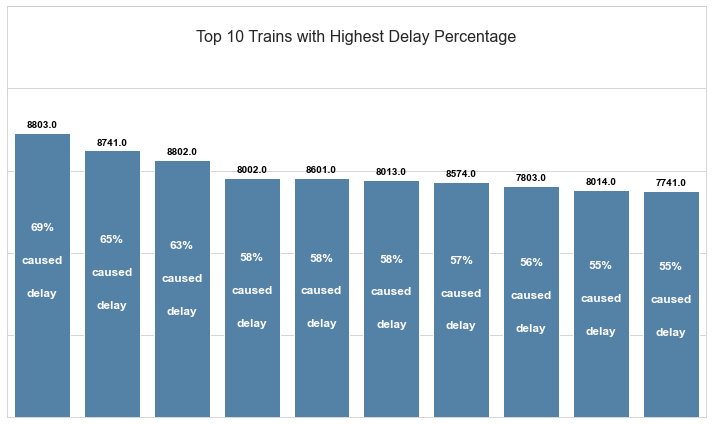

In [1381]:

# Sort the DataFrame by delay_perc in descending order and select the top 10 rows
top_10 = bad.nlargest(10, 'label_perc')

# Set the figure size
plt.figure(figsize=(10, 6))

# Plotting with Seaborn
sns.set_style('whitegrid')
ax = sns.barplot(x='TRAIN_NUMBER', y='label_perc', data=top_10, color='steelblue', order=top_10['TRAIN_NUMBER'])

# Add rounded percentages to each bar
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height / 1.5, f'{round(height * 100)}%',
            ha='center', va='center', color='white', weight='bold', fontsize=12)
    ax.text(p.get_x() + p.get_width() / 2, (height / 1.5) - 0.08, 'caused',
            ha='center', va='center', color='white', weight='bold', fontsize=12)
    ax.text(p.get_x() + p.get_width() / 2, (height / 1.5) - 0.16, 'delay',
            ha='center', va='center', color='white', weight='bold', fontsize=12)

# Remove ytick labels
ax.set_yticklabels([])

# Remove xtick labels
ax.set_xticklabels([])

# Add train numbers on top of the bars as black bold patches
for i, p in enumerate(ax.patches):
    ax.text(p.get_x() + p.get_width() / 2, p.get_height() + 0.02, top_10['TRAIN_NUMBER'].iloc[i],
            ha='center', va='center', color='black', weight='bold', fontsize=10)

plt.xlabel('')
plt.ylabel('')

# Set the title and adjust its position
ax.set_title('Top 10 Trains with Highest Delay Percentage', fontsize=16, y=0.9)

plt.ylim(0, 1)  # Set the y-axis limits from 0 to 1
plt.tight_layout()
plt.show()

In [206]:
basetable.dtypes.value_counts()

int64      9
float64    4
object     2
Name: count, dtype: int64

In [103]:
print(basetable['label'].value_counts(normalize=False))
print(basetable['label'].value_counts(normalize=True)[0])
print(basetable['label'].value_counts(normalize=True)[1])

label
0    41247
1    22162
Name: count, dtype: int64
0.6504912551845953
0.3495087448154047


In [142]:

# Split the data into training and testing sets
X = basetable.drop(columns=['label'], axis=1)
y = basetable['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123, stratify=y)

# define the categorical and numeric features to be transformed
cat_cols = ['day_origin']
numeric_features = ['stations_count', 'temperature', 'wind_speed', 'relative_humidity']

# initialize the scaler
scaler = StandardScaler()

# fit scaler on all the numeric variables
scaler.fit(X_train[numeric_features])

# scale features
X_train[numeric_features] = scaler.transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

# check
with pd.option_context('display.float_format', '{:.2f}'.format):
    print(X_train[numeric_features].describe())


       stations_count  temperature  wind_speed  relative_humidity
count        44386.00     44386.00    44386.00           44386.00
mean             0.00        -0.00        0.00               0.00
std              1.00         1.00        1.00               1.00
min             -1.91        -2.39       -1.75              -3.49
25%             -0.66        -0.67       -0.74              -0.51
50%             -0.16        -0.08       -0.17               0.26
75%              0.59         0.73        0.47               0.78
max              3.10         3.24        4.50               1.25


In [143]:
# create dummy variables for categorical features (such as last_family_indep)
X_train_dummies = pd.get_dummies(X_train[cat_cols])
X_train_dummies = X_train_dummies.astype(int) # binary for shap

X_test_dummies = pd.get_dummies(X_test[cat_cols])
X_test_dummies = X_test_dummies.astype(int) # binary for shap
X_test_dummies = X_test_dummies.reindex(columns = X_train_dummies.columns, fill_value=0)

#X_test_addition.drop(columns=['label', 'PAGERANK'], inplace=True) #'times_ahead', 'PAGERANK'], inplace=True)
#X_test_addition_dummies = pd.get_dummies(X_test_addition[cat_cols])
#X_test_addition_dummies = X_test_addition_dummies.astype(int) # binary for shap
#X_test_addition_dummies = X_test_addition_dummies.reindex(columns = X_train_dummies.columns, fill_value=0)

# add dummies to train/test, remove original columns
X_train = X_train.drop(columns=cat_cols)
X_train = pd.concat([X_train, X_train_dummies], axis=1)

X_test = X_test.drop(columns=cat_cols)
X_test = pd.concat([X_test, X_test_dummies], axis=1)

#X_test_addition = X_test_addition.drop(columns=cat_cols)
#X_test_addition = pd.concat([X_test_addition, X_test_addition_dummies], axis=1)
#X_test_addition = X_test_addition.merge(network_char_example_trains_copy[['TRAIN_NUMBER', 'W_INDEGREE', 'PAGERANK']], on='TRAIN_NUMBER', how='left')
#X_test_addition.rename(columns={'W_INDEGREE': 'times_ahead', 'W_OUTDEGREE': 'times_behind'}, inplace=True)

# control dataframes
X_train_id_trno = X_train

X_test_id_trno = X_test

X_all_id_trno = pd.concat([X_train, X_test]).reset_index(drop=True)

#X_test_addition_id_trno = X_test_addition

# remove control columns
X_train = X_train.drop(columns=['TRAIN_NUMBER', 'REF_TOD_TRAIN_ID', 'day_origin_Monday',
                                'day_origin_Sunday', 'day_origin_Thursday', 'day_origin_Tuesday'])

X_test = X_test.drop(columns=['TRAIN_NUMBER', 'REF_TOD_TRAIN_ID', 'day_origin_Monday',
                                'day_origin_Sunday', 'day_origin_Thursday', 'day_origin_Tuesday'])

#X_test_addition = X_test_addition.drop(columns=['TRAIN_NUMBER', 'REF_TOD_TRAIN_ID', 'day_origin_Monday',
#                                'day_origin_Sunday', 'day_origin_Thursday', 'day_origin_Tuesday'])

# check
X_train


,YEAR_DEP_2023,weekend,holiday,dep_hour_origin,morning_rush,stations_count,PAGERANK,leaves_falling,summer_vacation,precipitation,temperature,wind_speed,relative_humidity,wallonia,flanders,day_origin_Friday,day_origin_Wednesday
19169,0,0,0,0.422222,1,-0.409884,0.000062,0,0,0,1.379405,0.527282,-1.419596,0,0,0,0
9457,0,0,0,0.344444,1,0.341277,0.000035,0,1,0,0.624934,-1.225789,0.504118,1,1,0,0
10669,0,0,0,0.433333,0,1.593213,0.000217,0,1,0,0.998771,-0.314335,-1.339984,1,1,1,0
54872,1,0,0,0.316667,0,1.593213,0.000448,0,0,0,-1.091317,0.248828,-1.227080,0,1,0,0
32296,0,0,0,0.255556,0,-0.910659,0.000103,1,0,1,-0.428606,-0.589067,0.647420,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38752,0,0,0,0.444444,1,0.090890,0.000082,1,0,1,-1.366597,-0.469198,1.139566,0,1,0,0
8078,0,0,0,0.555556,1,0.341277,0.000276,0,1,0,0.438016,-0.894324,-0.290554,1,1,0,0
60059,1,0,0,0.516667,1,-0.159497,0.000035,0,0,0,-0.214500,1.830061,0.084346,0,1,0,1
23996,0,0,0,0.200000,0,0.591664,0.000504,1,0,1,-0.085356,-0.429291,1.015082,0,1,0,0


In [106]:
X_train.columns

Index(['YEAR_DEP_2023', 'weekend', 'holiday', 'dep_hour_origin',
       'morning_rush', 'stations_count', 'times_ahead', 'times_behind',
       'leaves_falling', 'summer_vacation', 'precipitation', 'temperature',
       'wind_speed', 'relative_humidity', 'wallonia', 'flanders',
       'day_origin_Friday', 'day_origin_Wednesday'],
      dtype='object')

In [ ]:
X_all_id_trno[X_all_id_trno['TRAIN_NUMBER'] == '8803.0']

In [144]:
# label encode the label

# initialise
lab_encoder = LabelEncoder()

# fit on training data
lab_encoder.fit(y_train)

# transform train and test
y_train = lab_encoder.transform(y_train)
y_test = lab_encoder.transform(y_test)

# check
y_test

array([0, 0, 0, ..., 1, 0, 0])

In [145]:
# Initial Model creation (Classification):

desired_pos_weight = (basetable['label'].value_counts()[0] / basetable['label'].value_counts()[1])


xgbc = XGBClassifier(objective='binary:logistic', seed=42, eta=0.1, n_jobs=8, scale_pos_weight = desired_pos_weight)

# Fit the classifier to the training data
xgbc.fit(X_train,
        y_train,
        verbose=True,
        early_stopping_rounds=10,
        eval_metric='aucpr',
        eval_set=[(X_test, y_test)])



[0]	validation_0-aucpr:0.67253
[1]	validation_0-aucpr:0.67378
[2]	validation_0-aucpr:0.67648
[3]	validation_0-aucpr:0.67741
[4]	validation_0-aucpr:0.68055
[5]	validation_0-aucpr:0.68269
[6]	validation_0-aucpr:0.68901
[7]	validation_0-aucpr:0.69166
[8]	validation_0-aucpr:0.69144
[9]	validation_0-aucpr:0.69264
[10]	validation_0-aucpr:0.69437
[11]	validation_0-aucpr:0.69684
[12]	validation_0-aucpr:0.69787
[13]	validation_0-aucpr:0.69867
[14]	validation_0-aucpr:0.69975
[15]	validation_0-aucpr:0.70083
[16]	validation_0-aucpr:0.70242
[17]	validation_0-aucpr:0.70383
[18]	validation_0-aucpr:0.70403
[19]	validation_0-aucpr:0.70475
[20]	validation_0-aucpr:0.70540
[21]	validation_0-aucpr:0.70567
[22]	validation_0-aucpr:0.70665
[23]	validation_0-aucpr:0.70727
[24]	validation_0-aucpr:0.70770
[25]	validation_0-aucpr:0.70828
[26]	validation_0-aucpr:0.70869
[27]	validation_0-aucpr:0.70845
[28]	validation_0-aucpr:0.70845
[29]	validation_0-aucpr:0.70871
[30]	validation_0-aucpr:0.70950
[31]	validation_0-

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=8,
              num_parallel_tree=None, predictor=None, ...)

In [845]:
# make random predictions for the test set, according to weights the labels occur
#y_pred = np.random.choice([0, 1], size=(len(y_test),), p=[1 - basetable['label'].value_counts(normalize=True)[1] * desired_pos_weight, basetable['label'].value_counts(normalize=True)[1] * desired_pos_weight])

In [146]:

# initial Model evaluation
# Predict the labels of the testing data
y_pred = xgbc.predict(X_test)
#y_pred = np.random.choice([0, 1], size=(len(y_test),), p=[1 - basetable['label'].value_counts(normalize=True)[1] * desired_pos_weight, basetable['label'].value_counts(normalize=True)[1] * desired_pos_weight])

# Calculate the evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Predict the class probabilities for the testing data
y_pred_proba = xgbc.predict_proba(X_test)[:, 1]

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)

print('Accuracy:', round(accuracy, 2))
print('Precision:', round(precision, 2))
print('Recall:', round(recall, 2))
print('F1 score:', round(f1, 2))
print(' - - - ')
print('AUC score:', round(auc_score, 2))

# calc classification report
print('classification report:')
print(classification_report(y_test, y_pred))

# calc balanced accurcary
print('balanced accuracy score:', round(balanced_accuracy_score(y_test, y_pred),2))

# calc balanced precision
print('balanced precision score:', round(precision_score(y_test, y_pred, average='weighted'),4))

# calc balanced recall
print('balanced recall score:', round(recall_score(y_test, y_pred, average='weighted'),4))

Accuracy: 0.76
Precision: 0.65
Recall: 0.65
F1 score: 0.65
 - - - 
AUC score: 0.81
classification report:
              precision    recall  f1-score   support

           0       0.81      0.81      0.81     12374
           1       0.65      0.65      0.65      6649

    accuracy                           0.76     19023
   macro avg       0.73      0.73      0.73     19023
weighted avg       0.76      0.76      0.76     19023

balanced accuracy score: 0.73
balanced precision score: 0.7561
balanced recall score: 0.7565


In [57]:
# grid search

# round 1
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.05, 0.01],
    'gamma': [0, 0.25, 1],
    'reg_lambda': [0, 1.0, 10.0],
    'scale_pos_weight': [1, desired_pos_weight, 5]
}

# for speed-up and avoiding overfitting we use a random subset of the data (90%) and a
# random subset of the features (50%) per tree
optimal_params = GridSearchCV(
    estimator=XGBClassifier(objective='binary:logistic',
                            seed=42,
                            subsample=0.9,
                            colsample_bytree=0.5),
    param_grid=param_grid,
    scoring='roc_auc',
    verbose=0,
    n_jobs=10,
    cv=3
)

optimal_params.fit(X_train,
                   y_train,
                   early_stopping_rounds=10,
                   eval_metric='auc',
                   eval_set=[(X_test, y_test)],
                   verbose=False)

print(optimal_params.best_params_)
# best found: {'gamma': 1, 'learning_rate': 0.1, 'max_depth': 5, 'reg_lambda': 1.0, 'scale_pos_weight': 2.7083275299850995}

/Users/miek/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/miek/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/miek/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/miek/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in c

{'gamma': 1, 'learning_rate': 0.1, 'max_depth': 5, 'reg_lambda': 1.0, 'scale_pos_weight': 2.7083275299850995}


In [814]:
# Tuned Model creation:

xgbc = XGBClassifier(objective='binary:logistic',
                     seed=42,
                     eta=0.1,
                     max_depth=5,
                     gamma=1,
                     reg_lambda=1,
                     scale_pos_weight = desired_pos_weight,
                     subsample=0.9,
                     colsample_bytree=0.5,
                     n_jobs=10)

# Fit the classifier to the training data
xgbc.fit(X_train,
        y_train,
        verbose=False,
        early_stopping_rounds=10,
        eval_metric='aucpr',
        eval_set=[(X_test, y_test)])


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric=None,
              feature_types=None, gamma=1, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=10,
              num_parallel_tree=None, predictor=None, ...)

In [738]:

# Model evaluation
# Predict the labels of the testing data
y_pred = xgbc.predict(X_test)

# Calculate the evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Predict the class probabilities for the testing data
y_pred_proba = xgbc.predict_proba(X_test)[:, 1]

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)

print('Accuracy:', round(accuracy, 2))
print('Precision:', round(precision, 2))
print('Recall:', round(recall, 2))
print('F1 score:', round(f1, 2))
print(' - - - ')
print('AUC score:', round(auc_score, 2))

# calc classification report
print('classification report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.85
Precision: 0.46
Recall: 0.48
F1 score: 0.47
 - - - 
AUC score: 0.8
classification report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.91     16256
           1       0.46      0.48      0.47      2580

    accuracy                           0.85     18836
   macro avg       0.69      0.69      0.69     18836
weighted avg       0.85      0.85      0.85     18836



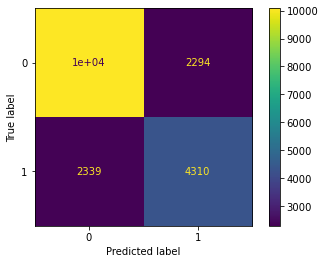

In [147]:
cm = confusion_matrix(y_test, y_pred, labels=xgbc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=xgbc.classes_)
disp.plot()

In [148]:
# Feature importances:

importances = xgbc.feature_importances_


sorted_indices = np.argsort(importances)[::-1][:10]
 


indices = importances.argsort()[::-1][:10] # get the indices of the top 10 most important features
for i in indices:
    print(f"{i+1}. {X_train.columns[i]}: {round(importances[i], 2)}")
#fig, ax = plt.subplots(figsize=(20, 14)) 
#plt.title('Feature Importance')
#plt.bar(range(X_train.shape[1]), importances[sorted_indices], align='center')
#plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
#plt.tight_layout()
#plt.show()

15. flanders: 0.23000000417232513
7. PAGERANK: 0.2199999988079071
6. stations_count: 0.11999999731779099
14. wallonia: 0.07000000029802322
5. morning_rush: 0.05999999865889549
8. leaves_falling: 0.05000000074505806
9. summer_vacation: 0.05000000074505806
4. dep_hour_origin: 0.03999999910593033
1. YEAR_DEP_2023: 0.029999999329447746
2. weekend: 0.029999999329447746


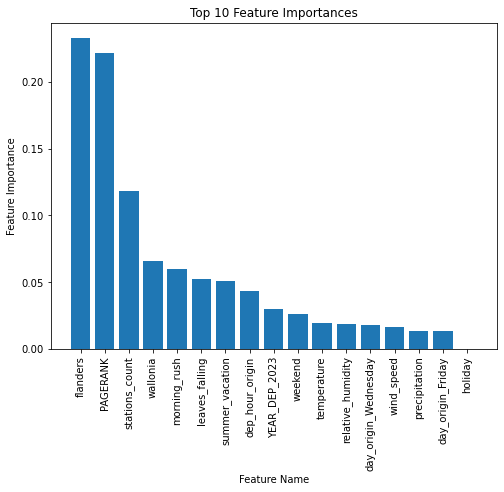

In [149]:
# Get feature importances and sort them in descending order
importances = xgbc.feature_importances_
indices = np.argsort(importances)[::-1]

# Select the top 30 features
top_indices = indices[:30]
top_importances = importances[top_indices]

# Get the corresponding feature names
feature_names = X_train.columns
top_feature_names = [feature_names[i] for i in top_indices]

# Plot the top 30 features and their importances
plt.figure(figsize=(8,6))
plt.bar(range(len(top_importances)), top_importances)
plt.xticks(range(len(top_importances)), top_feature_names, rotation=90)
plt.xlabel('Feature Name')
plt.ylabel('Feature Importance')
plt.title('Top 10 Feature Importances')
plt.show()

In [150]:
# Create an explainer object for the random forest classifier
tree_explainer = shap.TreeExplainer(xgbc)

# Calculate the SHAP values for a single instance
shap_values = tree_explainer.shap_values(X_test)

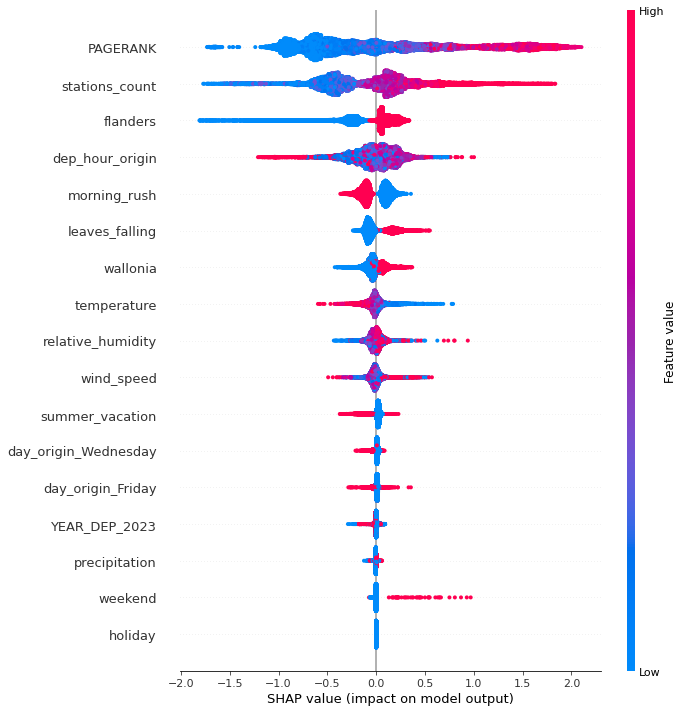

<Figure size 432x288 with 0 Axes>

In [151]:
# get summary plot
shap.summary_plot(shap_values, X_test, max_display=20, plot_size=(10, 10))

plt.tight_layout()

In [274]:
# Reduce candidate number of features with shap values

# write function to do feature selection based on shap values
def feature_selection_shap(model, X, y, threshold):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    shap_abs_mean = np.abs(shap_values).mean(axis=0)
    shap_abs_mean_df = pd.DataFrame(list(zip(X.columns, shap_abs_mean)), columns=['feature','shap_abs_mean'])
    shap_abs_mean_df.sort_values(by=['shap_abs_mean'], ascending=False, inplace=True)
    shap_abs_mean_df.reset_index(drop=True, inplace=True)
    shap_abs_mean_df['cum_sum'] = shap_abs_mean_df['shap_abs_mean'].cumsum()
    shap_abs_mean_df['cum_perc'] = 100*shap_abs_mean_df['cum_sum']/shap_abs_mean_df['shap_abs_mean'].sum()
    shap_abs_mean_df = shap_abs_mean_df[shap_abs_mean_df['cum_perc'] <= threshold]
    return shap_abs_mean_df

# get feature selection df
shap_abs_mean_df = feature_selection_shap(xgbc, X_train, y_train, 95)

# get list of selected features
selected_candidate_features = shap_abs_mean_df['feature'].tolist()

# check
shap_abs_mean_df


,feature,shap_abs_mean,cum_sum,cum_perc
0,times_ahead,0.570561,0.570561,30.852077
1,stations_count,0.312665,0.883226,47.758888
2,times_behind,0.305692,1.188918,64.288605
3,dep_hour_origin,0.134883,1.323801,71.582161
4,PAGERANK,0.115451,1.439252,77.824997
5,morning_rush,0.098496,1.537748,83.150963
6,month_8.0,0.049620,1.587368,85.834084
7,month_7.0,0.038435,1.625803,87.912384
8,month_11.0,0.035650,1.661453,89.840080
9,month_12.0,0.031784,1.693237,91.558746


In [29]:
selected_candidate_features = X_train.columns.tolist()

# Borutashap to further reduce features
selector = BorutaShap(importance_measure='shap', classification=True)

# Fit the selector with random sample of the training dataset
selector.fit(X=X_train[selected_candidate_features], y=y_train, n_trials=100,
                random_state=42, sample=True, train_or_test='test', verbose=True)

  0%|          | 0/100 [00:00<?, ?it/s]

## Explanation of observed: Force Plots

In [56]:
X_test2 = X_test
%store X_test2

xgbc2 = xgbc
%store xgbc2

Stored 'X_test2' (DataFrame)
Stored 'xgbc2' (XGBClassifier)


In [57]:
# Create an explainer object for the random forest classifier
tree_explainer = shap.TreeExplainer(xgbc)

# Calculate the SHAP values for a single instance
shap_values = tree_explainer.shap_values(X_test)

# 12347
i = 45
print(f"Class: {y_test[i]}")
shap.force_plot(tree_explainer.expected_value, shap_values[i,:], X_test.iloc[i,:], link="logit")

Class: 1


In [149]:
network_char_example_trains2 = pd.read_csv('./data/network_char_example_trains_newtrains_5mins_weighted.csv') # remove "_newtrains" for only real obs
network_char_example_trains2['TRAIN_NUMBER'] = network_char_example_trains2['TRAIN_NUMBER'].astype(str) + '.0'
network_char_example_trains2

,TRAIN_NUMBER,PAGERANK,INDEGREE,OUTDEGREE,W_INDEGREE,W_OUTDEGREE,1003_0_ATHUS-FRONTIERE,1015_0_ESSEN-GRENS,1026_0_1838.0,1026_0_MEER-GRENS,1042_941_SCHAARBEEK-GROEP R,1042_941_Y.SCHAARBEEK-CARWASH,1064_0_1026.0,1112_0_1003.0,1156_0_959.0,1158_0_GOUVY-FRONTIERE,1162_0_1169.0,1164_0_1156.0,1166_0_1164.0,1169_0_1166.0,1172_0_787.0,1209_0_631.0,1292_0_735.0,1293_0_803.0,145_0_783.0,145_0_799.0,156_0_787.0,1596_2019_OOSTKAMP,1596_598_BRUGGE,1831_0_1899.0,1838_0_MEER-GRENS,1899_0_1938.0,1899_0_735.0,1915_0_803.0,1933_0_1172.0,...,ZEDELGEM_893_TORHOUT,ZEDELGEM_893_ZEDELGEM-ROOSTER E/G,ZEEBRUGGE-DORP_1889_ZEEBRUGGE-ROOSTER H,ZEEBRUGGE-ROOSTER F_1766_LISSEWEGE,ZEEBRUGGE-ROOSTER F_1883_ZEEBRUGGE-ROOSTER G,ZEEBRUGGE-ROOSTER G_1883_ZEEBRUGGE-ROOSTER F,ZEEBRUGGE-ROOSTER G_1903_ZEEBRUGGE-VORMING,ZEEBRUGGE-ROOSTER H_1889_ZEEBRUGGE-DORP,ZEEBRUGGE-ROOSTER H_1903_ZEEBRUGGE-VORMING,ZEEBRUGGE-VORMING_1903_ZEEBRUGGE-ROOSTER G,ZEEBRUGGE-VORMING_1903_ZEEBRUGGE-ROOSTER H,ZELE_1326_DENDERMONDE,ZELE_1327_LOKEREN,ZELLIK_1329_ASSE,ZELLIK_1329_GRENS BRUSSEL-VLAANDEREN L60,ZICHEM_1039_DIEST,ZICHEM_1039_TESTELT,ZINGEM_480_EINE,ZINGEM_755_GAVERE-ASPER,ZOLDER-KRUISSPOREN_1134_ZOLDER,ZOLDER-KRUISSPOREN_687_HEUSDEN,ZOLDER_1134_ZOLDER-KRUISSPOREN,ZOLDER_1134_ZONHOVEN,ZONHOVEN-ROOSTER P/U_1134_ZONHOVEN,ZONHOVEN-ROOSTER P/U_1135_Y.ZONHOVEN,ZONHOVEN_1134_ZOLDER,ZONHOVEN_1134_ZONHOVEN-ROOSTER P/U,ZOTTEGEM_106_HILLEGEM,ZOTTEGEM_561_BALEGEM-ZUID,ZOTTEGEM_673_LIERDE,ZOTTEGEM_674_MUNKZWALM,ZWIJNDRECHT-ROOSTER D_1311_ANTWERPEN-ZUID,ZWIJNDRECHT-ROOSTER D_1312_ZWIJNDRECHT,ZWIJNDRECHT_1312_Y.ZWIJNDRECHT-FORT,ZWIJNDRECHT_1312_ZWIJNDRECHT-ROOSTER D
0,10.0,0.000331,1,2,1.0,25.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,11.0,0.000176,2,2,5.0,5.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,12.0,0.000267,1,4,1.0,11.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,13.0,0.000139,2,1,3.0,5.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,14.0,0.000264,1,3,5.0,22.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5921,108958.0,0.000130,1,1,4.0,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5922,108960.0,0.000136,2,2,11.0,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
5923,108979.0,0.000043,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5924,108984.0,0.000043,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [128]:
os.getcwd()

'/Users/miek/Documents/DS4B/DS4BThesisSNCB'

In [129]:
y_pred_proba_df = pd.DataFrame(y_pred_proba, columns=['y_pred_proba'])
y_pred_proba_df

,y_pred_proba
0,0.279212
1,0.382827
2,0.209666
3,0.168888
4,0.346881
...,...
19018,0.176975
19019,0.144045
19020,0.460221
19021,0.413459


In [130]:
y_pred_proba_df.to_csv('./data/new_train_effects/y_pred_proba_50early_50late.csv')

In [26]:

# example array of predicted probabilities
# find the indexes of the ten highest and lowest values
top_indexes = y_pred_proba.argsort()[-10:][::-1]
bottom_indexes = y_pred_proba.argsort()[:10]

print("Indexes of top 10 values:", top_indexes)
print("Indexes of bottom 10 values:", bottom_indexes)



Indexes of top 10 values: [ 7989  3469   238   191 13000  1734  6066  2576  3742 18824]
Indexes of bottom 10 values: [13664 15315  3819  1756  1303 17710  3412   731 18387  3776]


In [27]:
# high example
print(y_test[top_indexes[1]])
shap.force_plot(tree_explainer.expected_value, shap_values[top_indexes[1],:], X_test.iloc[top_indexes[1],:], link="logit")

0


In [52]:
# Create an explainer object for the random forest classifier
tree_explainer = shap.TreeExplainer(xgbc)

# Calculate the SHAP values for a single instance
shap_values = tree_explainer.shap_values(X_test_addition)

# get summary plot
shap.summary_plot(shap_values, X_test_addition, max_display=15, plot_size=(10, 10))

plt.tight_layout()

[21:27:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:1517: Empty dataset at worker: 0


IndexError: index 0 is out of bounds for axis 0 with size 0

In [51]:
shap_values_addition = tree_explainer.shap_values(X_test_addition)

i = 6
shap.force_plot(tree_explainer.expected_value, shap_values_addition[i,:], X_test_addition.iloc[i,:], link="logit")

[21:26:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:1517: Empty dataset at worker: 0


IndexError: index 0 is out of bounds for axis 0 with size 0

In [1580]:
# plot waterfall plot with legend of feature names and values
explainer2 = shap.Explainer(xgbc, X_test)
shap_values2 = explainer(X_test)

shap.plots.waterfall(shap_values2[[1], :], max_display=7, show=False)
plt.tight_layout()

ValueError: This reshape error is often caused by passing a bad data matrix to SHAP. See https://github.com/slundberg/shap/issues/580

In [1005]:
# low example
print(y_test[bottom_indexes[1]])
shap.force_plot(explainer.expected_value, shap_values[bottom_indexes[1],:], X_test.iloc[bottom_indexes[1],:], link="logit")


KeyError: 8874

In [113]:
# random example
print(y_test[123])
shap.force_plot(explainer.expected_value, shap_values[123,:], X_test.iloc[123,:], link="logit")

0


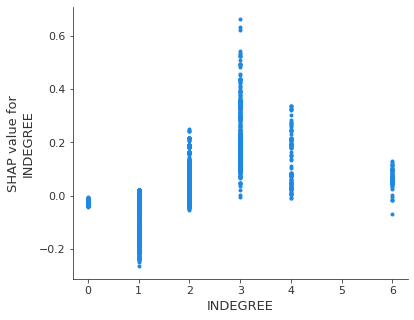

In [522]:
# The first argument is the index of the feature we want to plot
# The second argument is the matrix of SHAP values (it is the same shape as the data matrix)
# The third argument is the data matrix (a pandas dataframe or numpy array)
shap.dependence_plot(X_test.columns.get_loc('INDEGREE'), shap_values, X_test, interaction_index=None)

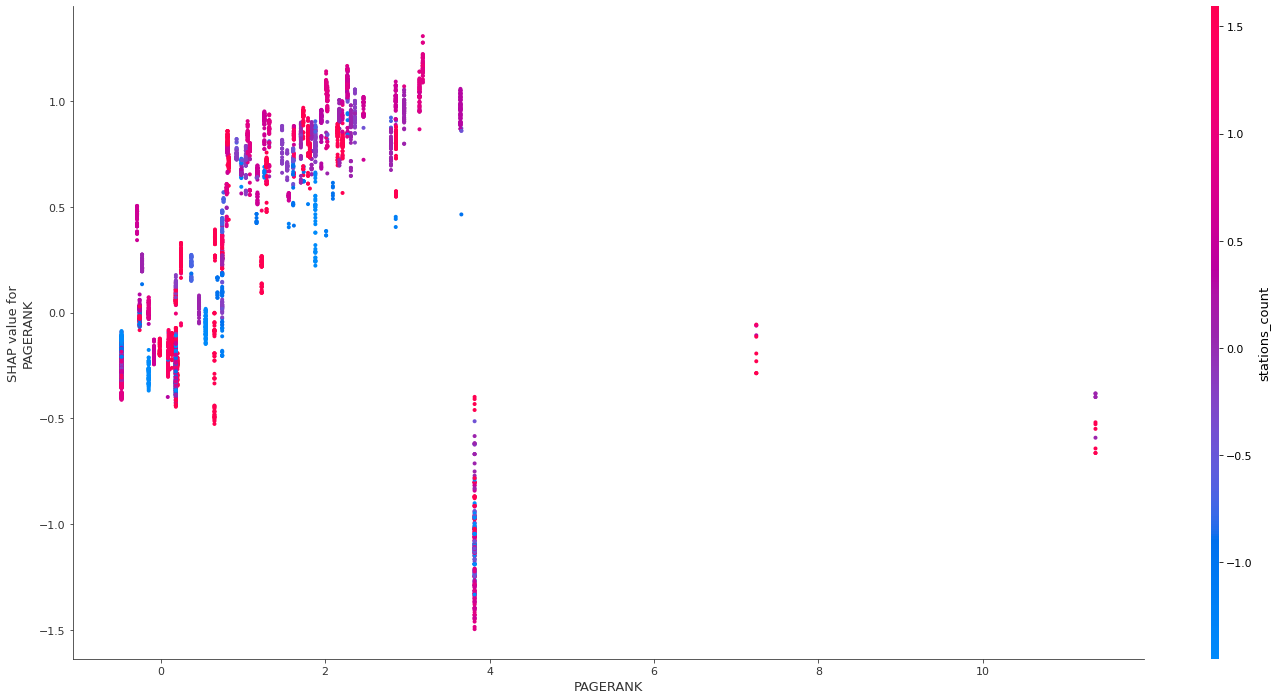

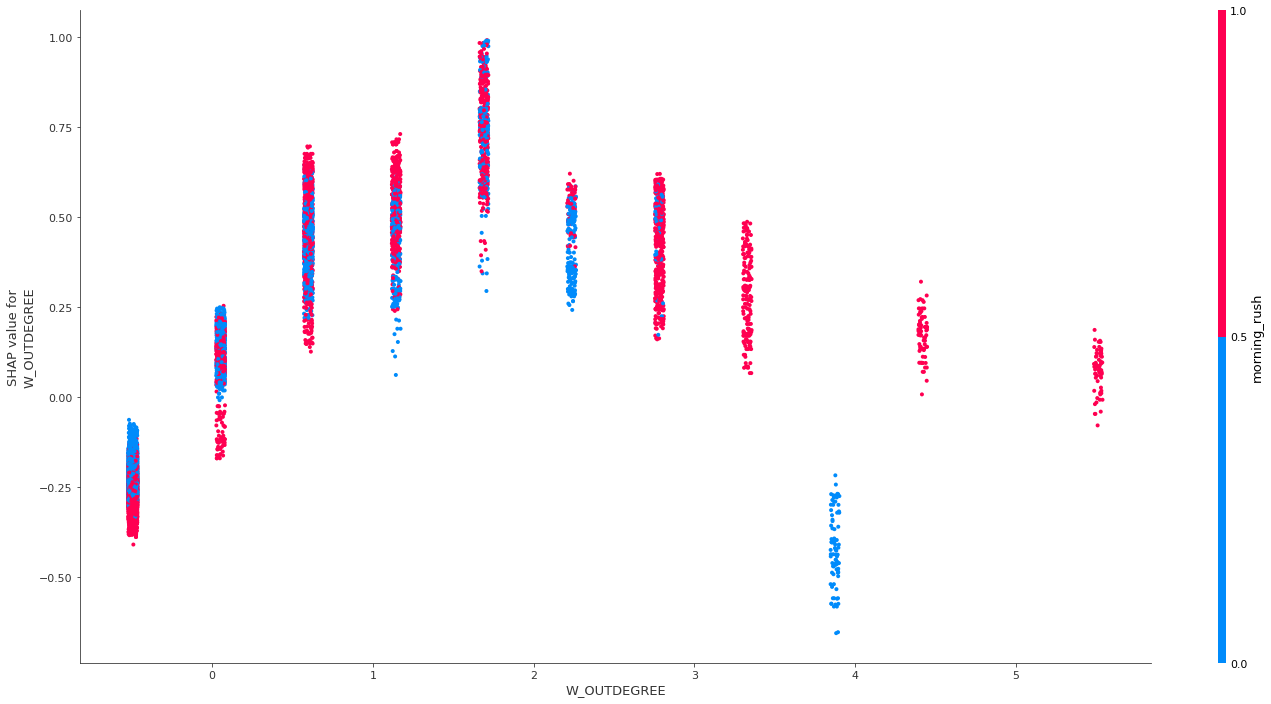

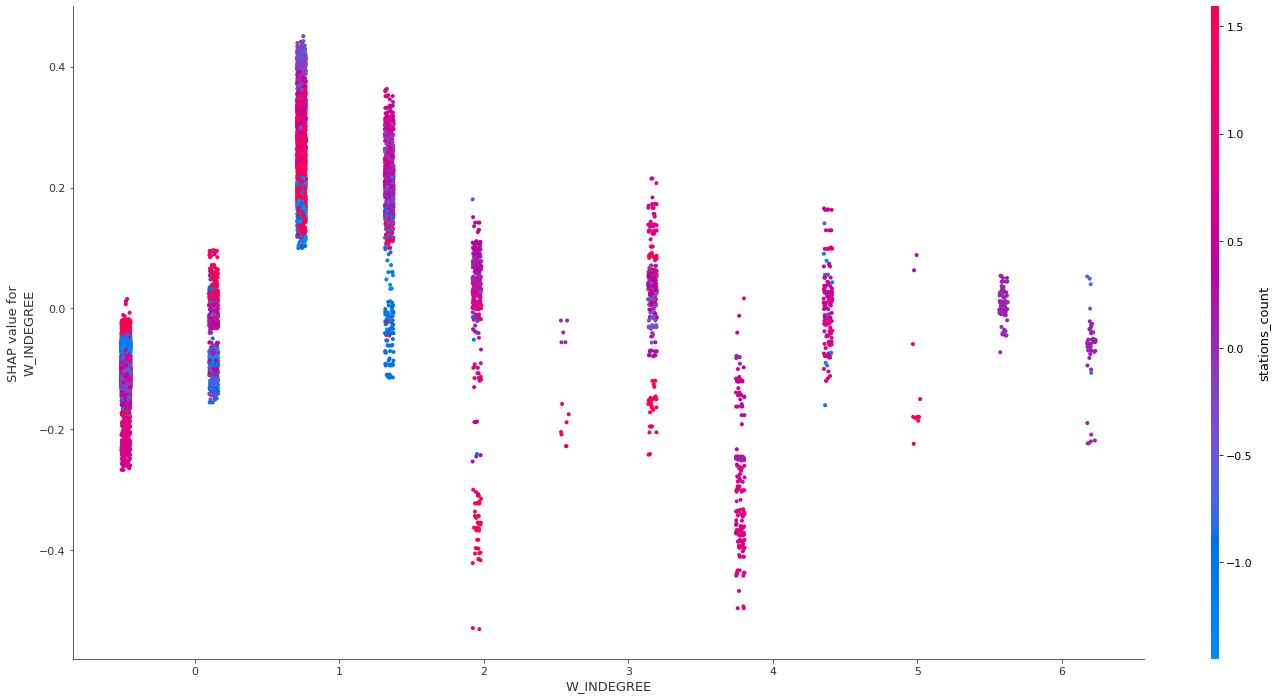

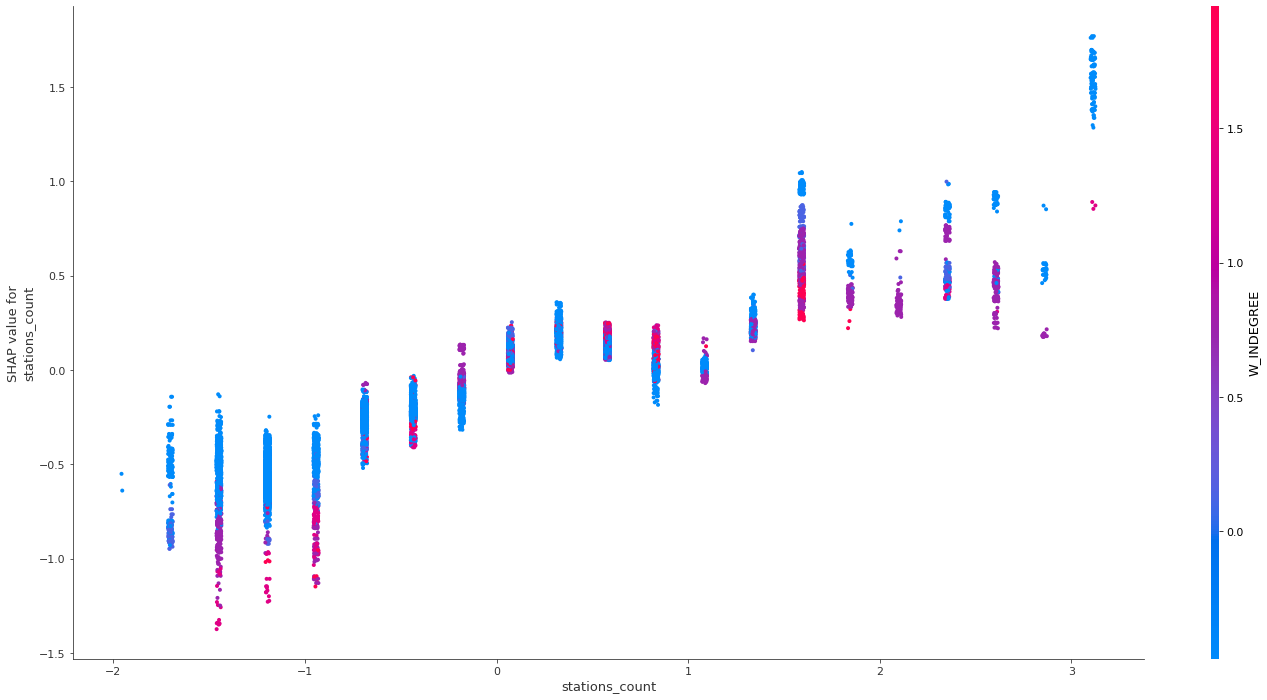

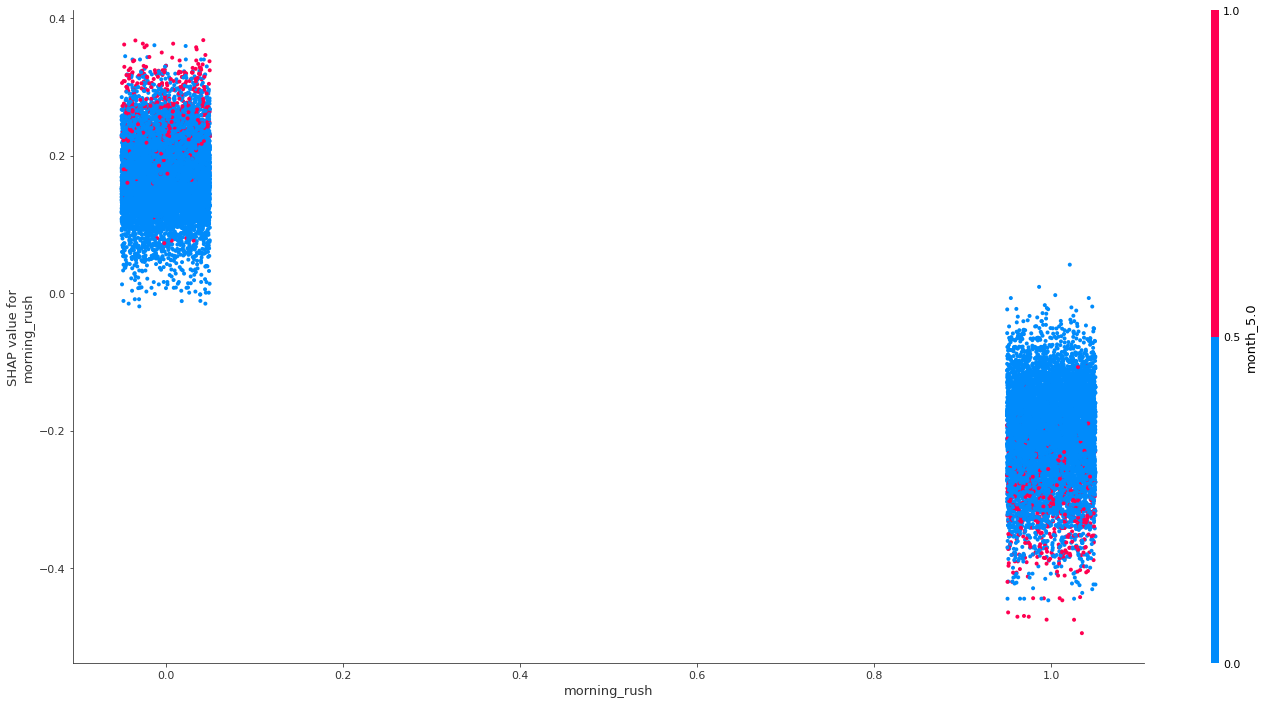

In [119]:
# check shap and interaction effects
shap_values = explainer.shap_values(X_test)
for feat_name in  X_train.columns[sorted_indices][:5]:
    shap.dependence_plot(f"{feat_name}", shap_values, X_test, show = False, x_jitter = .1)

    plt.gcf().set_size_inches(24, 12)
    # Show the plot
    plt.show()